# Analyzing a custom S2MSI2A product created with FORCE-EO

### Introduction

We now take a look at an example where we perform batch processing to calculate NDVI on a custom Sentinel-2 MSI Level 2a product that we created with [FORCE-EO](https://force-eo.readthedocs.io/en/latest/). The notebook also aims to demonstrate a basic workflow when working with geospatial data and satellite data. Typically, you don't start with a ready-made polygon, instead you need to extract a polygon or bounding box from an existing image. 

### Objective

This notebook will show how to:

1. Extract a bounding box from a GeoTiff
2. Calculate NDVI inside the bounding box
3. Scale the calculation using batch processing

All this on a Sentinel-2 MSI Level 2a product that we have **created specifically to be used in Swedish terrain**. 

### In this notebook, you will explore the following concepts:

- **Working with satellite data**: Learn how to work with satellite data in practise, scaling a calculation from daily level to multiple months or even years.
- **Custom data products**: Work with an experimental satellite data product created by the Digital Earth Sweden team to serve the needs of the public in Sweden.

### Tools You'll Use:

- **openEO**: To build process graphs, execute them synchronously, or submit them as asynchronous jobs.
- **Python**: Learn how to work with satellite data using common Python packages like rasterio and pyproj.

### Learning Outcomes

By the end of this tutorial, you will be able to:

- Choose between batch job execution and synchronous download .
- Calculate NDVI for a specific polygon, scale the calculation.
- Perform a full workflow, from fetching a polygon to executing a calculation at scale.
- Introduction to a custom satellite data product created specifically to suit Swedish terrain.


BoundingBox(left=608540.0, bottom=6698300.0, right=608860.0, top=6698620.0)


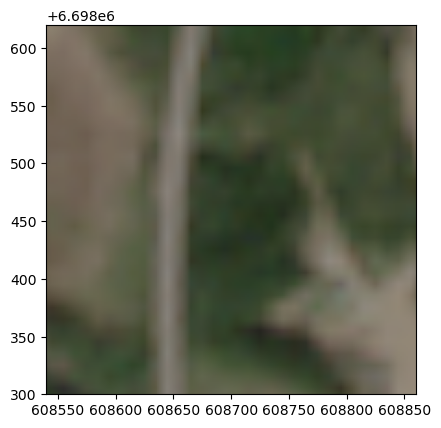

In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
# Read file, print bounding box and plot
with rasterio.open('../input/sentinel2_small_RGB.tiff') as src:
    img = src.read()
    bounds = src.bounds
    print(bounds)
    fig, ax = plt.subplots()
    show(img, transform=src.transform, ax=ax)

In [2]:
from pyproj import Transformer
# Transform the coordinates to EPSG:4326
transformer = Transformer.from_crs("EPSG:3006", "EPSG:4326")
# Coordinates are flipped compared to how rasterio sees it
ymin, xmin  = transformer.transform(bounds.bottom, bounds.left)
ymax, xmax = transformer.transform(bounds.top, bounds.right)

# Define bounding boxes
bboxes = {
  "forest": {
    "west": xmin,
    "south": ymin,
    "east": xmax,
    "north": ymax
  },
  # We picked out a piece of agricultural land in Sweden in advance, feel free to change to a polygon of your own
  "land": {
    "west": 14.180696612459913,
    "south": 56.938379992280694,
    "east": 14.19466162985175,
    "north": 56.94601297412865
  }
}

## Authorize and authenticate towards Digital Earth Sweden OpenEO client

If your organisation is connected to EGI you can authenticate with OIDC with your regular work email. Please check this, if you are successful you can either:

1. Use the test user
2. Contact digital-earth-se-admin@ri.se to recieve a user

To use the test user replace the code below with the following:

```
import openeo
from config import user,passwd,eo_service_url
connection = openeo.connect(eo_service_url)
connection.authenticate_basic(username=user, password=passwd)
```

In [3]:
import openeo
eo_service_url = "https://openeo.digitalearth.se"
conn = openeo.connect(eo_service_url)
conn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.digitalearth.se/' with OidcBearerAuth>

In [4]:
conn.list_collections()

[{'stac_version': '1.0.0',
  'type': 'Collection',
  'id': 'NMD_2018_Basskikt_v1_1',
  'title': 'NMD_2018_Basskikt_v1_1',
  'description': 'Nationella marktäckedata (NMD)',
  'license': 'CC0-1.0',
  'extent': {'spatial': {'bbox': [[7.69749988516237,
      54.7899686180128,
      25.49198053351633,
      68.99393398837026]]},
   'temporal': {'interval': [['2024-08-28T08:30:02.384349Z',
      '2024-08-28T08:30:02.384349Z']]}},
  'links': [{'rel': 'root',
    'href': 'https://explorer.digitalearth.se/stac',
    'type': 'application/json',
    'title': 'Default ODC Explorer instance'},
   {'rel': 'self',
    'href': 'https://explorer.digitalearth.se/stac/collections/NMD_2018_Basskikt_v1_1'},
   {'rel': 'items',
    'href': 'https://explorer.digitalearth.se/stac/collections/NMD_2018_Basskikt_v1_1/items'},
   {'rel': 'http://www.opengis.net/def/rel/ogc/1.0/queryables',
    'href': 'https://explorer.digitalearth.se/stac/collections/NMD_2018_Basskikt_v1_1/queryables'},
   {'rel': 'child',
    'href': 'https://explorer.digitalearth.se/stac/catalogs/NMD_2018_Basskikt_v1_1/2024-8'}],
  'cube:dimensions': {'x': {'type': 'spatial',
    'axis': 'x',
    'extent': [7.69749988516237, 25.49198053351633],
    'reference_system': 4326},
   'y': {'type': 'spatial',
    'axis': 'y',
    'extent': [54.7899686180128, 68.99393398837026],
    'reference_system': 4326},
   't': {'type': 'temporal',
    'extent': ['2024-08-28T08:30:02.384349Z', '2024-08-28T08:30:02.384349Z'],
    'step': None},
   'bands': {'type': 'bands', 'values': ['Basskikt']}},
  'summaries': {}},
 {'stac_version': '1.0.0',
  'type': 'Collection',
  'id': 'NMD_2018_Produktivitet_v1_1',
  'title': 'NMD_2018_Produktivitet_v1_1',
  'description': 'Tilläggsskikt produktivitet',
  'license': 'CC0-1.0',
  'extent': {'spatial': {'bbox': [[7.69749988516237,
      54.7899686180128,
      25.49198053351633,
      68.99393398837026]]},
   'temporal': {'interval': [['2024-08-28T08:29:35.374342Z',
      '2024-08-28T08:29:35.374342Z']]}},
  'links': [{'rel': 'root',
    'href': 'https://explorer.digitalearth.se/stac',
    'type': 'application/json',
    'title': 'Default ODC Explorer instance'},
   {'rel': 'self',
    'href': 'https://explorer.digitalearth.se/stac/collections/NMD_2018_Produktivitet_v1_1'},
   {'rel': 'items',
    'href': 'https://explorer.digitalearth.se/stac/collections/NMD_2018_Produktivitet_v1_1/items'},
   {'rel': 'http://www.opengis.net/def/rel/ogc/1.0/queryables',
    'href': 'https://explorer.digitalearth.se/stac/collections/NMD_2018_Produktivitet_v1_1/queryables'},
   {'rel': 'child',
    'href': 'https://explorer.digitalearth.se/stac/catalogs/NMD_2018_Produktivitet_v1_1/2024-8'}],
  'cube:dimensions': {'x': {'type': 'spatial',
    'axis': 'x',
    'extent': [7.69749988516237, 25.49198053351633],
    'reference_system': 4326},
   'y': {'type': 'spatial',
    'axis': 'y',
    'extent': [54.7899686180128, 68.99393398837026],
    'reference_system': 4326},
   't': {'type': 'temporal',
    'extent': ['2024-08-28T08:29:35.374342Z', '2024-08-28T08:29:35.374342Z'],
    'step': None},
   'bands': {'type': 'bands', 'values': ['Produktivitet']}},
  'summaries': {}},
 {'stac_version': '1.0.0',
  'type': 'Collection',
  'id': 's2_msi_l1c',
  'title': 's2_msi_l1c',
  'description': 'Sentinel-2 Level1C - Ortho Rectified Top of Atmosphere Reflectance',
  'license': 'CC-BY-4.0',
  'extent': {'spatial': {'bbox': [[-180.0,
      54.9150072246983,
      179.94744409098163,
      69.4096405079696]]},
   'temporal': {'interval': [['2015-07-06T10:50:16.027000Z',
      '2025-04-14T10:46:41.025000Z']]}},
  'links': [{'rel': 'root',
    'href': 'https://explorer.digitalearth.se/stac',
    'type': 'application/json',
    'title': 'Default ODC Explorer instance'},
   {'rel': 'self',
    'href': 'https://explorer.digitalearth.se/stac/collections/s2_msi_l1c'},
   {'rel': 'items',
    'href': 'https://explorer.digitalearth.se/stac/collections/s2_msi_l1c/items'},
   {'rel': 'http://www.opengis.net/def

As we can see here, we have the **s2_msi_l2a_des_force_experimental** collection that we will target for this analysis.

In [5]:
# Define time steps
one_day = ["2024-06-02T00:00:00Z", "2024-06-02T23:59:59Z"]
summer_2024 = ["2024-05-01", "2024-09-01"]

## Analyse FORCE-EO S2MSI2A product on a patch of forest in Sweden

In [6]:
# Declare collections that define what analysis is going to be performed
one_day_cube=conn.load_collection(
    "s2_msi_l2a_des_force_experimental",
    spatial_extent=bboxes["forest"],
    # One day
    temporal_extent=one_day,
    bands=['B04','B08'])

summer_cube=conn.load_collection(
    "s2_msi_l2a_des_force_experimental",
    spatial_extent=bboxes["forest"],
    # Summer 2024
    temporal_extent=summer_2024,
    bands=['B04','B08'])

If you want to remove cloudy images you can for example specify `properties={"eo:cloud_cover":  lambda val: val < 20}` in the "summer cube" above. Next step is to build the NDVI process, download the data, and plot the index.

In [7]:
# Build NDVI
one_day_ndvi = one_day_cube.ndvi(nir="B08",red="B04")
summer_ndvi = summer_cube.ndvi(nir="B08",red="B04")

In [8]:
# Execute the one day NDVI Process
res = one_day_ndvi.download(format="gtiff")

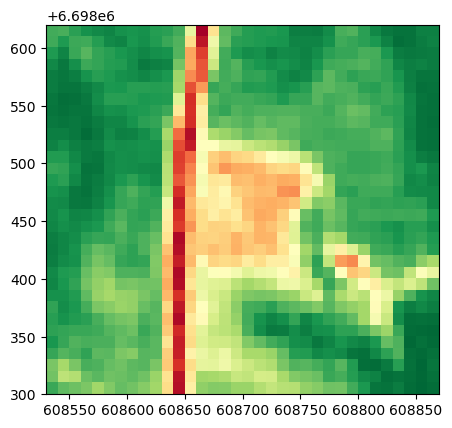

In [9]:
import io
# Plot with colour map that is compatible with NDVI
with io.BytesIO(res) as filelike:
    with rasterio.open(filelike) as im:
        fig, ax = plt.subplots()
        show(im, cmap="RdYlGn", ax=ax)

In [10]:
# Creating a batch job for the summer NDVI process defined in previous cell
job = summer_ndvi.create_job(
    out_format="GTiff",
    title="NDVI Batch on FORCE-EO L2A product",
    description="Calculating NDVI for selected area for ESTHub demo",
    options={"max_files":100})

In [11]:
# Execute job
job.start_and_wait()

0:00:00 Job '56a6eb1b-3254-413d-a28d-0b013581408b': send 'start'
0:00:00 Job '56a6eb1b-3254-413d-a28d-0b013581408b': queued (progress 0.0%)
0:00:05 Job '56a6eb1b-3254-413d-a28d-0b013581408b': running (progress 0.0%)
0:00:11 Job '56a6eb1b-3254-413d-a28d-0b013581408b': running (progress 0.0%)
0:00:19 Job '56a6eb1b-3254-413d-a28d-0b013581408b': running (progress 0.0%)
0:00:29 Job '56a6eb1b-3254-413d-a28d-0b013581408b': running (progress 0.0%)
0:00:41 Job '56a6eb1b-3254-413d-a28d-0b013581408b': finished (progress 0.0%)


<BatchJob job_id='56a6eb1b-3254-413d-a28d-0b013581408b'>

In [12]:
result = job.get_results()
assets = result.get_assets()

**NOTE!** This will place the result in a local folder named "results/forest_ndvi" and the code picks out the 6 first images from this folder. If you wish to change the folder you will need to adapt the code accordingly!

In [14]:
for a in assets:
    if a.name.endswith(".tif"):
        a.download(f"results/forest_ndvi/{a.name}")

In [15]:
logs=conn.job('0ca47156-4961-4609-82ad-84acc733e219').logs()

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import os

# List of 6 file names of the downloaded .tif images
path = "results/forest_ndvi/"
raster_files = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".tif"):
            if len(raster_files) > 6:
                break
            else:
                raster_files.append(os.path.join(root, file))

Now we can plot a sample of the images.

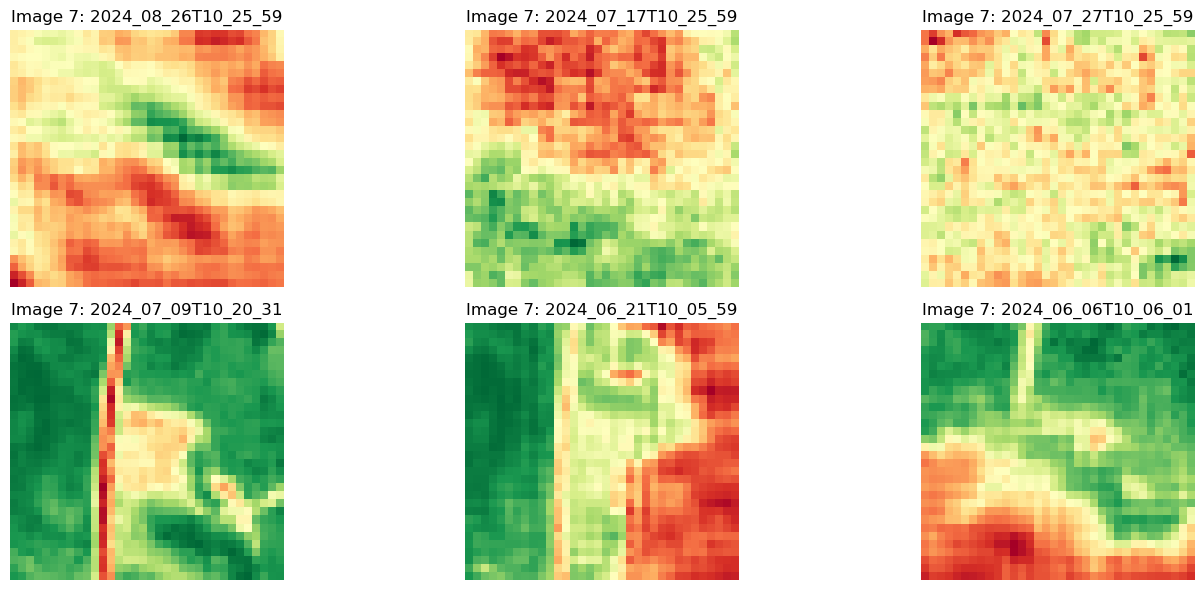

In [29]:
num_images = len(raster_files)

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

# Loop through each file path and read the image
for k, f in enumerate(raster_files):
    with rasterio.open(f) as src:
        # Read the NDVI array
        image = src.read(1)

    # Get the subplot axis
    ax = axes[(k // 3) - 1, k % 3]

    # Display the image
    ax.imshow(image, cmap="RdYlGn")
    ax.set_title(f'Image {i+1}: {f.strip(path).strip(".tif")}')
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

## Analyse FORCE-EO S2MSI2A product on a pasture in Sweden

In [32]:
# Collection for agricultural land
land_cube=conn.load_collection(
    "s2_msi_l2a_des_force_experimental",
    # Land instead of forest
    spatial_extent=bboxes["land"],
    # One day
    temporal_extent=one_day,
    bands=['B04','B08'])

In [33]:
land_ndvi = land_cube.ndvi(nir="B08",red="B04")

In [34]:
land_res = land_ndvi.download(format="gtiff")

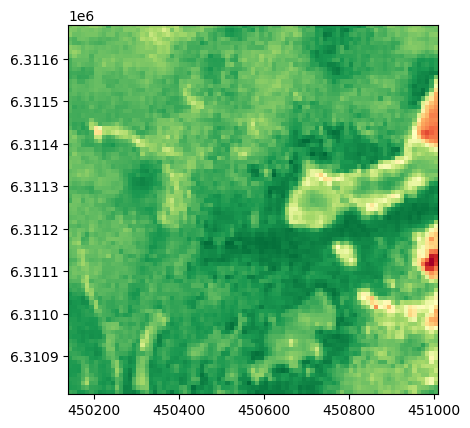

In [35]:
# Plot with colour map that is compatible with NDVI
with io.BytesIO(land_res) as filelike:
    with rasterio.open(filelike) as im:
        fig, ax = plt.subplots()
        show(im, cmap="RdYlGn", ax=ax)